In [177]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [178]:
# Note: CSV pre-processing
# 1. Remove header and footer
# 2. Replace ,"" with blank
# 3. Check for error messages

In [179]:
DAYS_OF_THE_WEEK = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}

MONTHS = {'JANUARY': 1, 'FEBRUARY': 2, 'MARCH': 3, 'APRIL': 4, 'MAY': 5, 'JUNE': 6, 
          'JULY': 7, 'AUGUST': 8, 'SEPTEMBER': 9, 'OCTOBER': 10, 'NOVEMBER': 11, 'DECEMBER': 12}

ACTIVITIES = {'Sleeping': 1,  'Browsing':   2,  'Socializing': 3,  'Education': 4,
              'Homework': 5,  'Eating':     6,  'Shower':      7,  'Work':      8,
              'Travel':   9,  'Exercising': 10, 'Job Search':  11, 'Guitar':    4,
              'Darts':    3,  'Robotics':   4, 'Part-Time':   8}

COLOUR_MAP = ["#ffc31f", "#4b0085", "#bc11bf", "#28d43f",
              "#2cc7c4", "#0c9e05", "#1664d9", "#e8621a",
              "#098551", "#1b1063", "#737373"]

CHUNKS_PER_DAY = 24 * 12    # 24 hours, 12 chunks per hour

In [180]:
year = 2018     # Start year
month = 3       # March
day = 12

daylight_savings = []

# Before recording activities, find the daylight saving days
with open('data.csv', 'r') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        # Date row --> "MONDAY, MARCH 12"
        if len(row) == 1:
            month = MONTHS[row[0].split(" ")[1]]
            day = int(row[0].split(" ")[2])
            day_of_week = DAYS_OF_THE_WEEK[row[0].split(", ")[0]]
            
            # Increment the new year
            if month == 1 and day == 1:
                year += 1
                
        elif len(row) == 2:
            total_time = row[1]
            if total_time != "24:00":
                # Daylight savings only happen in March and November
                if (month == 3 and total_time == "23:00") or (month == 11 and total_time == "25:00"):
                    daylight_savings.append((year, month, day, int(total_time.split(":")[0]) * 12)) # Total chunks that day
                else:
                    print("Error: Total time doesn't match on ", year, month, day, total_time)
                    
# print(daylight_savings)

In [181]:
year = 2018     # Start year
month = 3       # March
day = 12
day_of_week = 1 # Monday

df = []
first_day = True    # Wether today is the first day of a multi-day activity

with open('data.csv', 'r') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        # Date row --> "MONDAY, MARCH 12"
        if len(row) == 1:
            month = MONTHS[row[0].split(" ")[1]]
            day = int(row[0].split(" ")[2])
            day_of_week = DAYS_OF_THE_WEEK[row[0].split(", ")[0]]
            
            # Start a new empty day
            daily = np.zeros(CHUNKS_PER_DAY)
            
            # Increment the new year
            if month == 1 and day == 1:
                year += 1
            
        # Activity row --> "Travel","9:25","10:00",0:35
        elif len(row) == 4:
            if row[0] in ACTIVITIES.keys():
                activity = ACTIVITIES[row[0]]
            else:
                print(f"Error: Activity doesn't exist: {row[0]}")
            
            # Convert time from "1:20" --> chunk 16
            # 1 chunk every 5 minuts; 12 chunks per hour
            start_time = (int(row[1].split(":")[0]) * 60 + int(row[1].split(":")[1])) // 5
            end_time = (int(row[2].split(":")[0]) * 60 + int(row[2].split(":")[1])) // 5
            duration = (int(row[3].split(":")[0]) * 60 + int(row[3].split(":")[1])) // 5
            
            # Update end time if activity ends exactly on midnight
            if end_time == 0:
                end_time = CHUNKS_PER_DAY
            
            # If an activity spans multiple days, it'll be recorded on both days
            if end_time < start_time:
                if first_day:
                    end_time = CHUNKS_PER_DAY
                    first_day = False
                else:
                    start_time = 0
                    first_day = True
            
            # Check activity length mismatch
            # Explicitly ignore daylight saving days since there'll always be a mismatch
            if end_time - start_time != duration:
                time_diff = end_time - start_time - duration    # In chunks
                
                # Ignore if the mismatched chunks are only in 1 activity and exactly accounted for by daylight savings
                if (year, month, day, CHUNKS_PER_DAY - time_diff) in daylight_savings:
                    pass
                else:
                    print("Error: Activity duration mismatch for ", year, month, day, row, time_diff)
                    
            daily[start_time:end_time] = activity
            
        # Time row --> Total,24:00
        elif len(row) == 2:
            # At the end of the day, add the daily activities to the dataframe
            df += [[year, month, day, day_of_week] + list(daily)]

In [182]:
# Convert chunks back into hh:mm format
df_columns = ['year', 'month', 'day', 'day_of_week'] + [str(i//12).zfill(2) + ':' + str(i%12 * 5).zfill(2) for i in range(288)]

df = pd.DataFrame(df, columns=df_columns, dtype=np.int32)

In [183]:
print(df.shape)
# print(df.head())
# print(df['00:00'].value_counts())

(2404, 292)


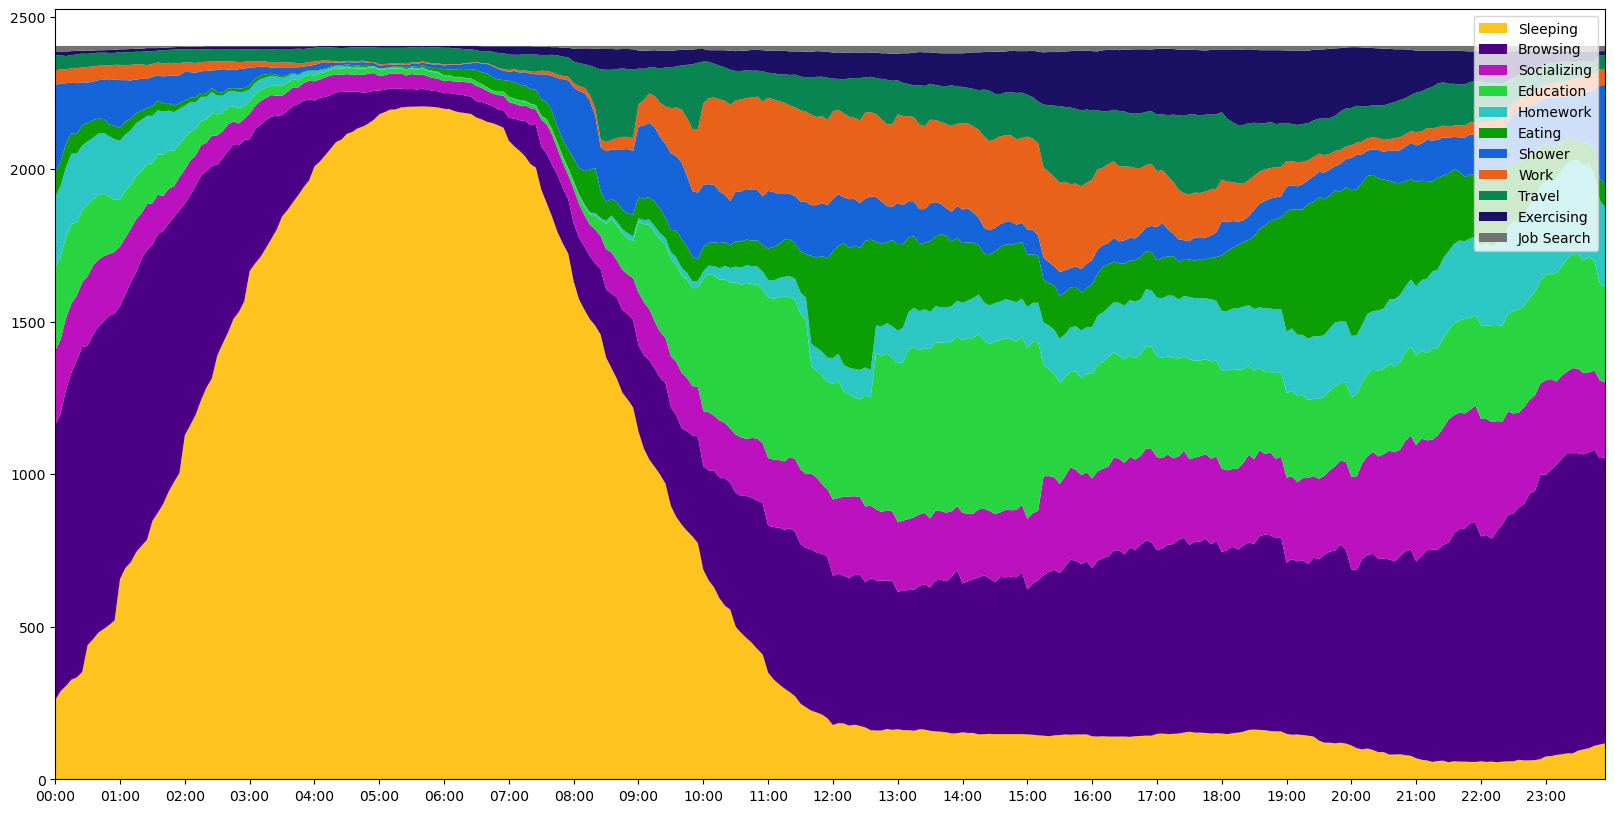

In [184]:
# Prepare the data for graphing
freq_df = pd.DataFrame(index=list(set(ACTIVITIES.values())))
for col in df.columns[4:]:
    freqs = df[col].value_counts()
    freq_df = pd.concat([freq_df, freqs], axis=1)
freq_df = freq_df.fillna(0)

# Plot the stacked area chart for a specific timeframe
plt.rcParams["figure.figsize"] = (20, 10)
plt.stackplot(df.columns[4:], freq_df.iloc[0], freq_df.iloc[1],
              freq_df.iloc[2], freq_df.iloc[3], freq_df.iloc[4],
              freq_df.iloc[5], freq_df.iloc[6], freq_df.iloc[7],
              freq_df.iloc[8], freq_df.iloc[9], freq_df.iloc[10],
            #   freq_df.iloc[11], freq_df.iloc[12], freq_df.iloc[13], freq_df.iloc[14], 
              labels=ACTIVITIES.keys(),
              colors=COLOUR_MAP)
plt.legend()
plt.xticks(df.columns[4::12])
plt.xlim([0, 287])
plt.show()

In [186]:
df.to_csv('output.csv')